In [1]:
from sympy import *
import numpy as np
import numpy.linalg as la
from scipy import stats

from matplotlib import pyplot as plt
font = {'fontname':'Times New Roman'}
size = {'fontsize':'14'}
#save_path = r'C:\Users\reape\Desktop\Sp24\NPRE 455\CP1\Plots\\'

np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

In [2]:
#Part B

#Assigning Variables
C0, C1, C2, C3, C4 = S('C0, C1, C2, C3, C4')
L1, L2, D1, D2, Source = S('L1, L2, D1, D2, S1')
a, b, x = S('a, b, x')

Flux1_ana = C0*sinh(x/L1) + C1*cosh(x/L1) + C2
Flux2_ana = C3*sinh(x/L2) + C4*cosh(x/L2)

print('Flux 1:')
display(Flux1_ana)
print('Flux 2:')
display(Flux2_ana)

#Solving for Coefficients
A_ana = Matrix([(0,0,-1/L1**2,0,0),
            (0,0,0,sinh((a+b)/L2),cosh((a+b)/L2)),
            (-D1/L1*cosh(0),-D1/L1*sinh(0),0,0,0),
            (-D1/L1*cosh(a/L1),-D1/L1*sinh(a/L1),0,D2/L2*cosh(a/L2),D2/L2*sinh(a/L2)),
            (sinh(a/L1),cosh(a/L1),1,-sinh(a/L2),-cosh(a/L2))])
B_ana = Matrix([-Source/D1,0,0,0,0])

C_ana = A_ana.inv()@B_ana

C_ana_subs = C_ana.subs([(a, 10), (L1, 10), (D1, 1), (b, 20), (L2, 5), (D2, 1.7), (Source, 10**12)])

print('Constants:')
display(C_ana_subs.evalf())

#Plugging Constants Into Flux
Flux1_ana_subs = (Flux1_ana.subs([(C0, C_ana_subs[0]), (C1, C_ana_subs[1]), (C2, C_ana_subs[2]), (L1, 10)])).evalf()
Flux2_ana_subs = (Flux2_ana.subs([(C3, C_ana_subs[3]), (C4, C_ana_subs[4]), (L2, 5)])).evalf()

print('Flux 1 w/ Constants:')
display(Flux1_ana_subs)
print('Flux 2 w/ Constants:')
display(Flux2_ana_subs)

Flux 1:


C0*sinh(x/L1) + C1*cosh(x/L1) + C2

Flux 2:


C3*sinh(x/L2) + C4*cosh(x/L2)

Constants:


Matrix([
[                 0],
[ -52952184388336.5],
[ 100000000000000.0],
[-135195785766794.0],
[ 135194124433768.0]])

Flux 1 w/ Constants:


100000000000000.0 - 52952184388336.7*cosh(x/10)

Flux 2 w/ Constants:


-135195785766794.0*sinh(x/5) + 135194124433767.0*cosh(x/5)

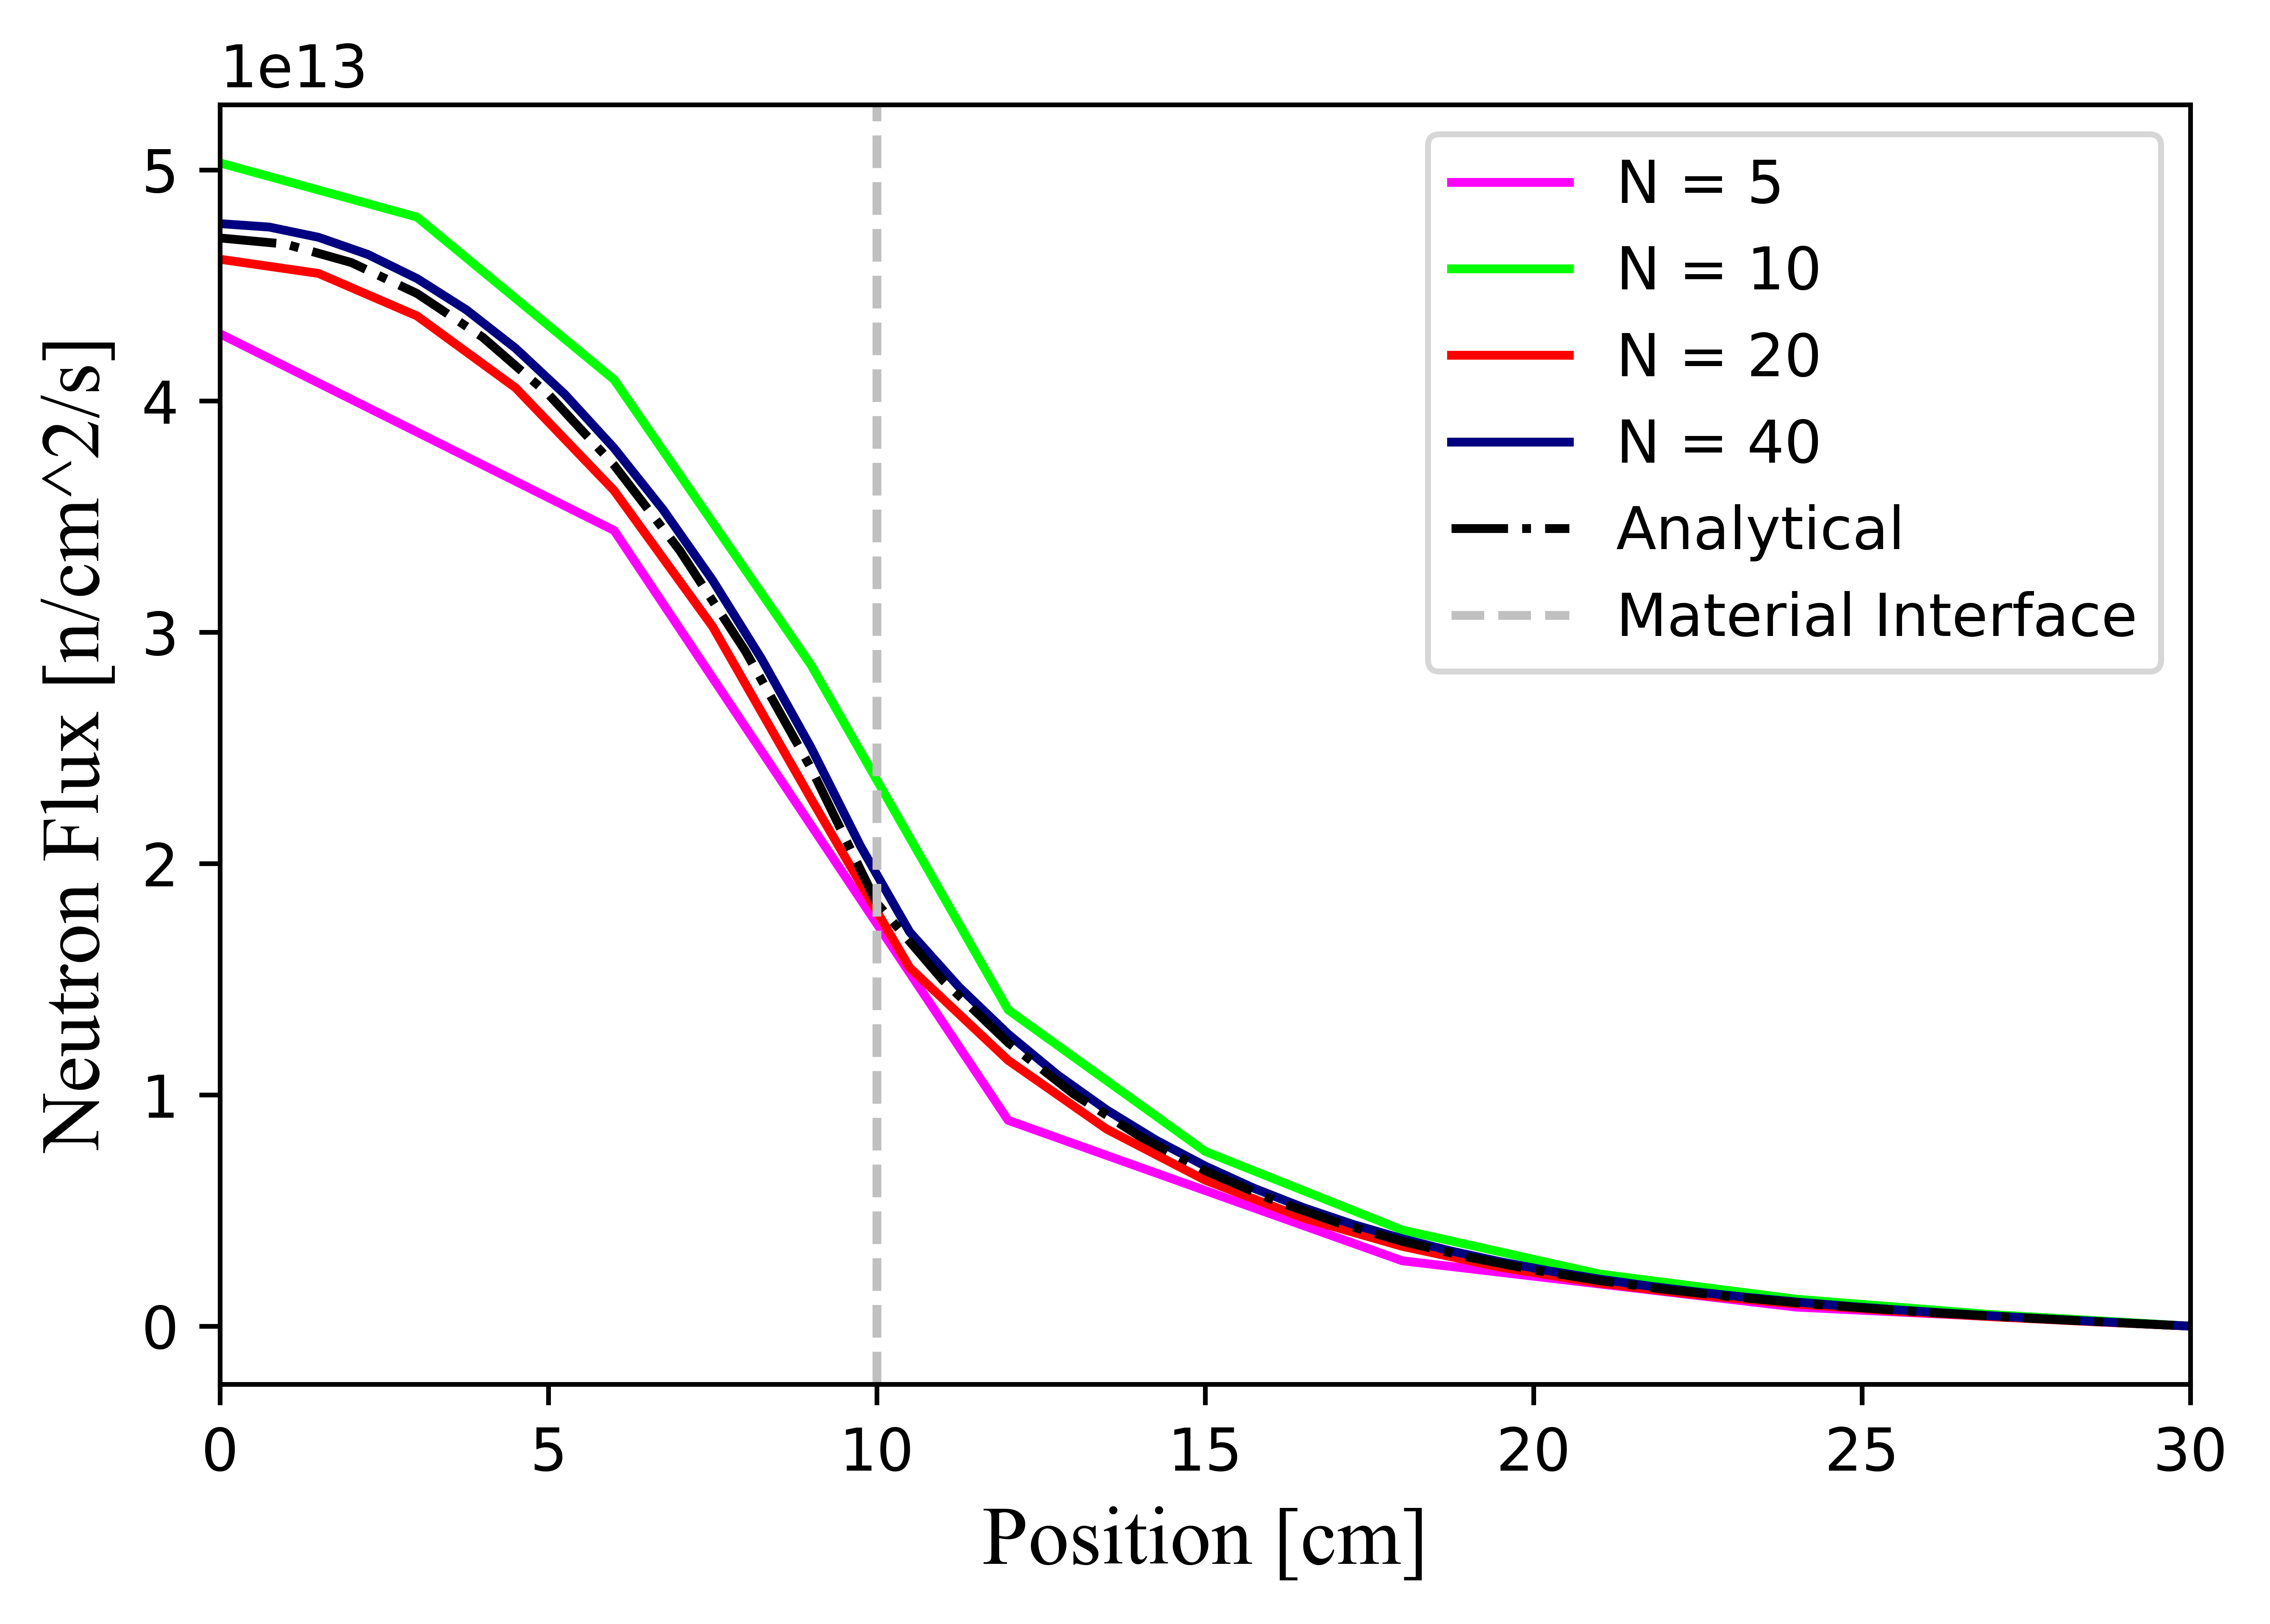

In [3]:
#Part D

#######################################Benninging of the Functions######################################################
def flux_num(N):
    x_pos = np.linspace(0,30,N+1)
    A_num = np.zeros((N+1, N+1))
    h = x_pos[1]

    #Constant Arrays
    D_arr = np.zeros(N+1)
    Sig_arr = np.zeros(N+1)
    
    for i in range(len(x_pos)):
        if x_pos[i] <= 10:
            D_arr[i] = 1 #D1
            Sig_arr[i] = 1/10**2 #SigmaA1
        else:
            D_arr[i] = 1.7 #D2
            Sig_arr[i] = 1.7/5**2 #SigmaA2
    
    S_arr = 10**12 * np.ones(len(x_pos)) #Source
    for i in range(len(x_pos)):
        if x_pos[i] > 10:
            S_arr[i] = 0
    S_arr[0] = S_arr[-1] = 0

    #Boundary Conditions
    np.put(A_num, (0,1,2), (-3,4,-1))
    A_num[-1,-1] = 1
    
    #Array Population
    for i in range(1, len(x_pos)-1):
        A_num[i,i-1] = -2*D_arr[i]/h**2*D_arr[i-1]/(D_arr[i-1]+D_arr[i]) #Lower Diag
        A_num[i,i] = 2*D_arr[i]/h**2*(D_arr[i-1]/(D_arr[i-1]+D_arr[i]) + D_arr[i+1]/(D_arr[i+1]+D_arr[i])) + Sig_arr[i] #On diag
        A_num[i,i+1] = -2*D_arr[i]/h**2*D_arr[i+1]/(D_arr[i+1]+D_arr[i]) #Upper Diag

    return la.solve(A_num, S_arr)


def flux_ana(N):
    x_pos_ana = np.linspace(0,30,N+1)
    Flux_ana = np.zeros(len(x_pos_ana))
    for i in range(len(x_pos_ana)):
        if x_pos_ana[i] <= 10:
            Flux_ana[i] = float(Flux1_ana_subs.subs(x, x_pos_ana[i]).evalf())
        else:
            Flux_ana[i] = float(Flux2_ana_subs.subs(x, x_pos_ana[i]).evalf())
    return Flux_ana


def flux_num_plotting(N, graph_color):
    plt.plot(np.linspace(0,30,N+1), flux_num(N), label = "N = {}".format(N), color = graph_color)


def flux_ana_plotting(N):
    plt.plot(np.linspace(0,30,N+1), flux_ana(N), label = "Analytical", color = 'black', linestyle = '-.')
#######################################End of the Functions#############################################################

#Plotting
N_array = np.array([5,10,20,40])
Color_array = np.array(['fuchsia', 'lime', 'red', 'navy'])

plt.figure(dpi=1000)
for i in range(len(N_array)):
    flux_num_plotting(N_array[i], Color_array[i])

flux_ana_plotting(30)
plt.axvline(10, color = 'silver', linestyle = '--', label = "Material Interface")
plt.xlim(0, 30)

plt.ylabel('Neutron Flux [n/cm^2/s]',**font, **size)
plt.xlabel('Position [cm]', **font, **size)
plt.legend()
#plt.savefig(save_path+'2D')
plt.show()

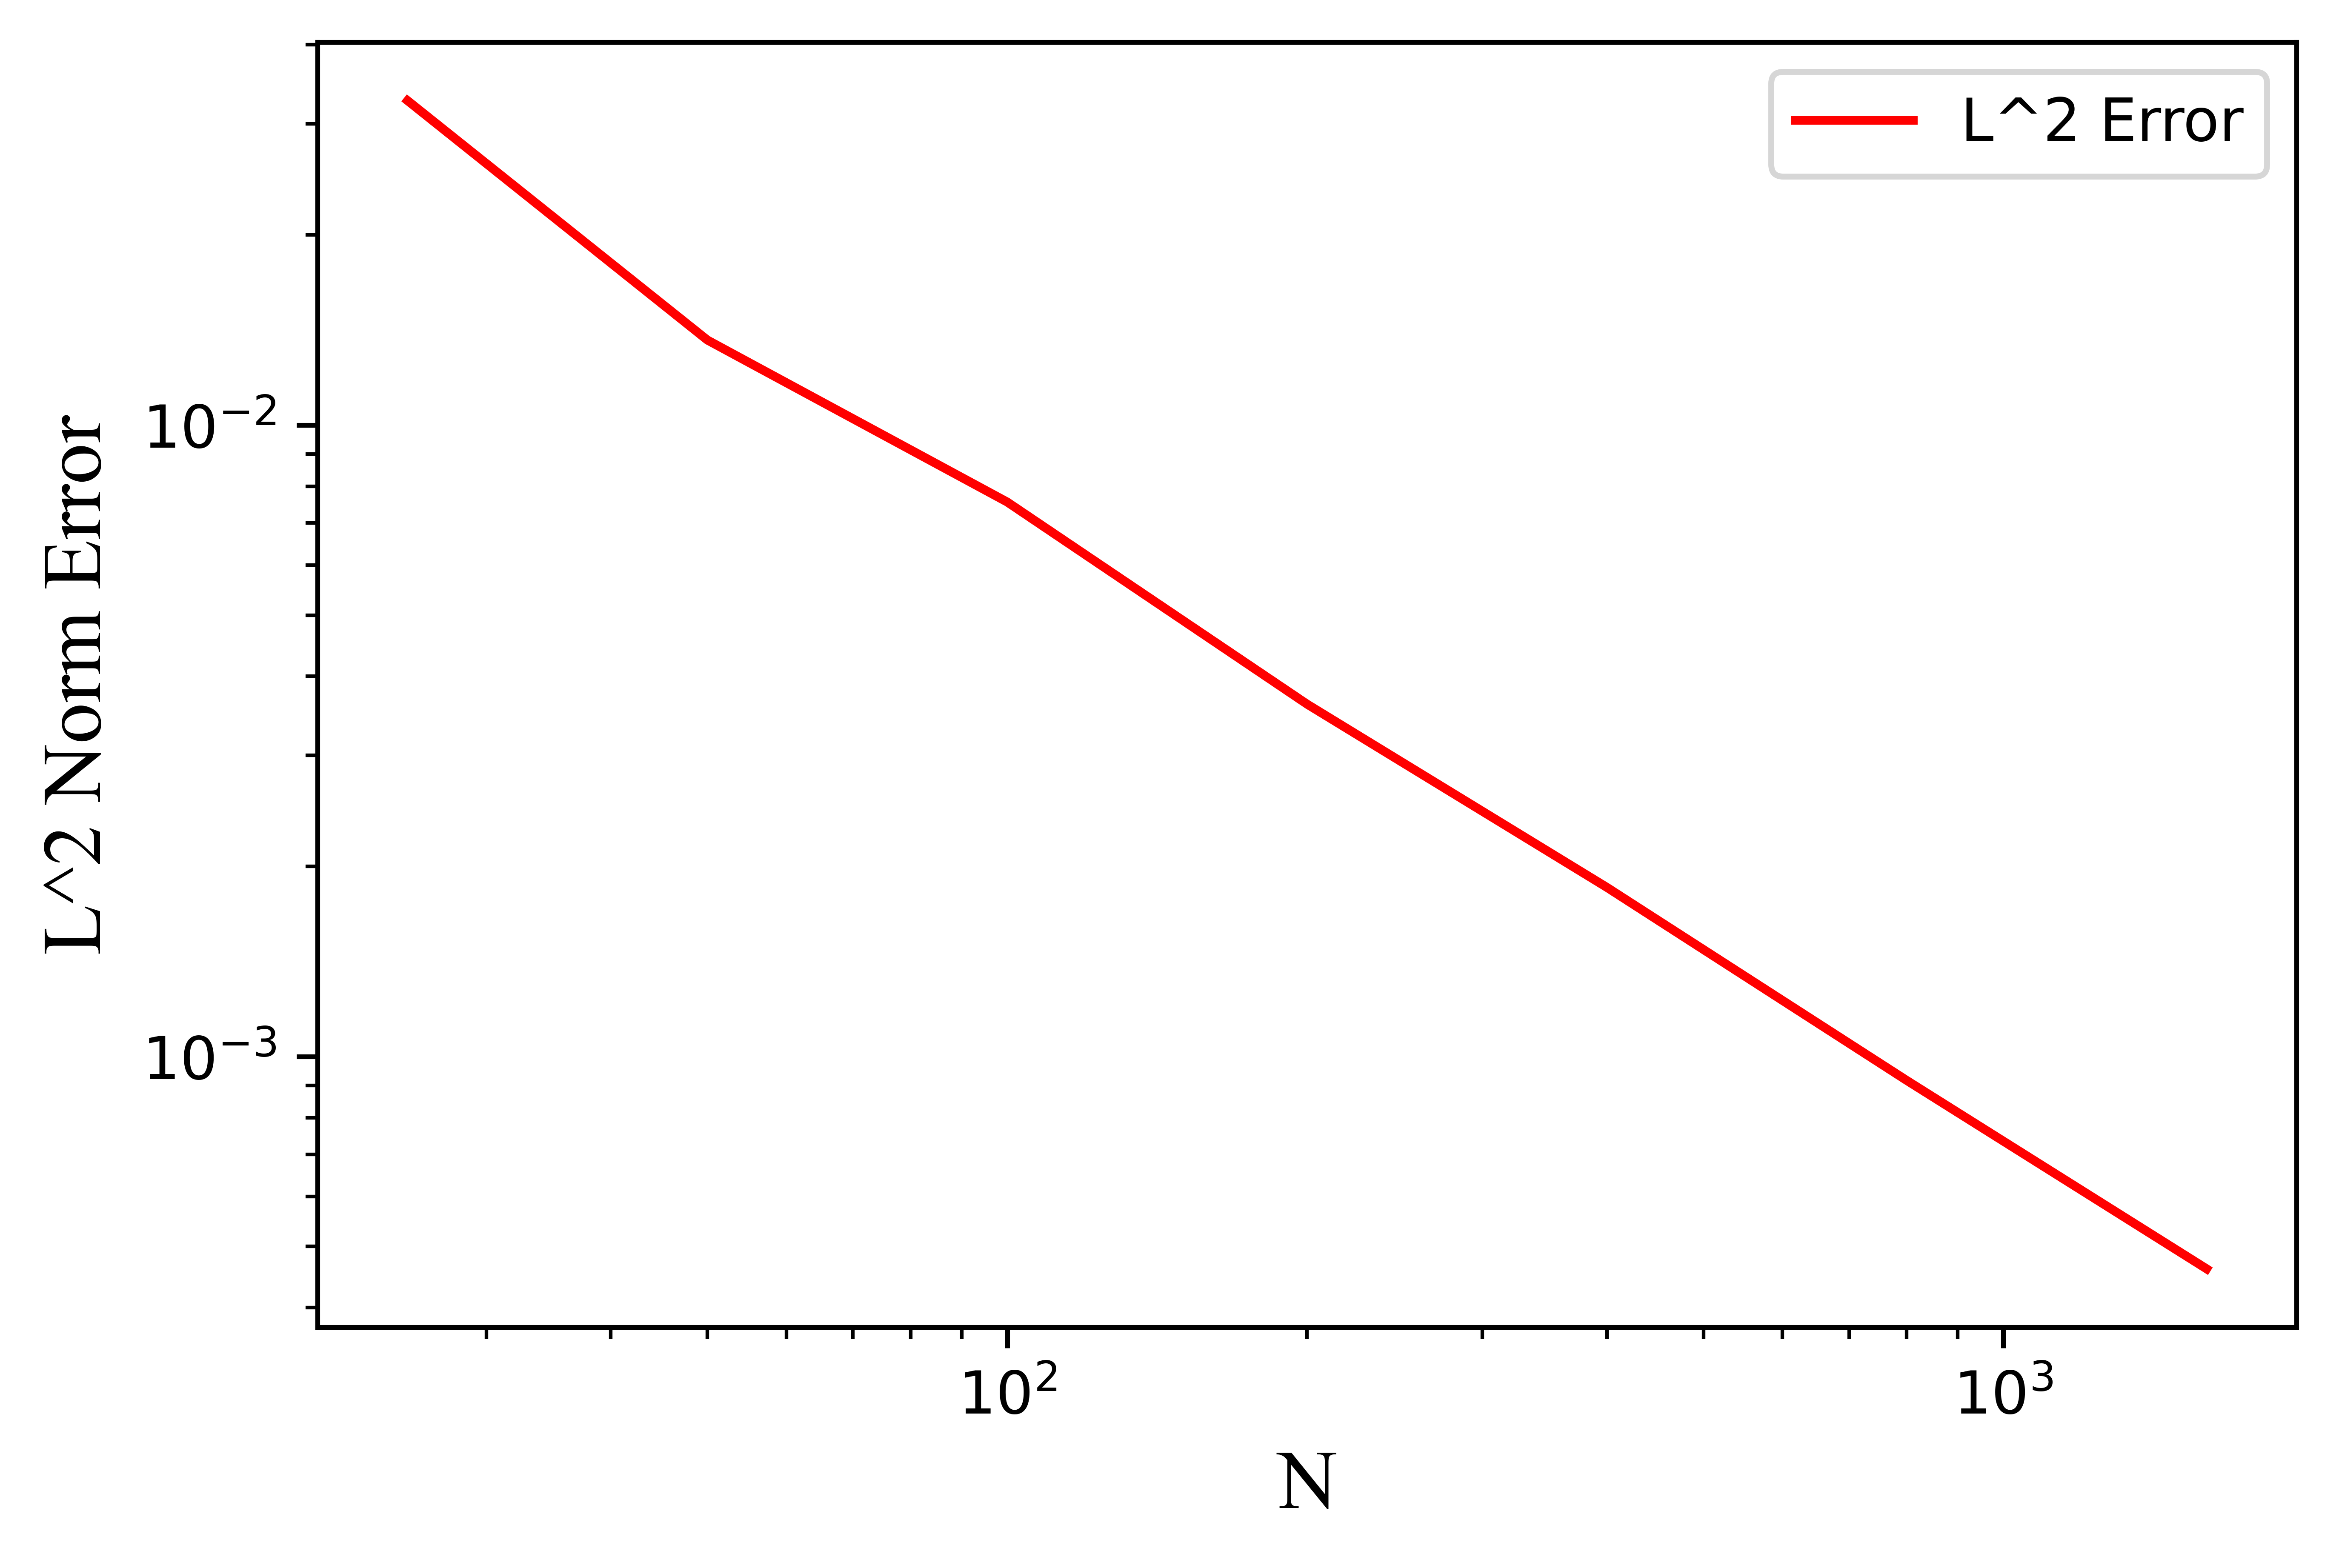

Slope / Order of Convergence:


-1.0091264986820925

In [4]:
#Part E
def num_error(N):
    fluxN = flux_num(N)
    fluxA = flux_ana(N)
    top = la.norm(fluxN-fluxA, 2) #L2 norm of the difference
    bot = la.norm(fluxA, 2) #L2 norm of Exact Flux
    return top/bot

#Plotting
Ne_array = np.array([25,50,100,200,400,800,1600])
error_array = np.zeros(len(Ne_array))

for i in range(len(Ne_array)):
    error_array[i] = num_error(Ne_array[i])

plt.figure(dpi=1000)
plt.loglog(Ne_array, error_array, label = "L^2 Error", color = 'red', linestyle = '-')

plt.xlabel('N',**font, **size)
plt.ylabel('L^2 Norm Error', **font, **size)
plt.legend()
#plt.savefig(save_path+'2E')
plt.show()

#Slope
slope = stats.linregress(np.log10(Ne_array), np.log10(error_array))
print('Slope / Order of Convergence:')
slope[0]